In [1]:
# Standard libraries
import os
import sys
import re
import itertools
import pickle

# Scientific libraries
import numpy as np
import pandas as pd
import mpmath

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.markers import MarkerStyle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib.ticker import (
    ScalarFormatter, LogLocator, LogFormatter, LogFormatterMathtext,
    AutoMinorLocator, MultipleLocator, NullFormatter
)

import seaborn as sns

# Geospatial
import geopandas as gpd

# Progress bar
from tqdm import tqdm

# Scipy
import scipy.optimize as opt
from scipy import stats, signal
from scipy.special import hyp2f1
from scipy.stats import linregress

# Figure settings
golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms, 8*cms)
fig_formats = ['.pdf', '.eps', '.tiff', '.png']

figsizes = {
    "1 column": (3.43, 3.43/golden),
    "1.5 columns": (4.49, 4.49/golden),
    "2 columns": (7.01, 7.01/golden)
}

# Color palettes
light_palette = ['#504B43', '#4caf50', '#948d99']
dark_palette = ['#285DB1', '#AC3127', '#c1bbb0']
color_clusters = ['#648fff', '#ffb000', '#948d99']
palettename = 'coolwarm'
palette_temp = sns.color_palette(palettename, 32)
paletteTGB = ['#4caf50', '#504B43', '#948d99']
metaTcolor, metaGcolor, metaBcolor = paletteTGB
metacolor = {'metaT': metaTcolor, 'metaG': metaGcolor, 'metaB': metaBcolor}
metamarker = {'metaT': 'o', 'metaG': 'd', 'metaB': 's'}

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Seaborn and matplotlib settings
sns.set_theme(
    rc={
        'figure.figsize': figsizes["2 columns"],
        'figure.dpi': 200,
        'savefig.dpi': 300
    },
    font="Helvetica Neue",
    font_scale=1.3,
    style="ticks"
)

plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['legend.facecolor'] = 'w'
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{sfmath}'
plt.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "text.latex.preamble": r"\usepackage{amsmath, helvet} \renewcommand{\familydefault}{\sfdefault}"
})

# Jupyter autoreload
%reload_ext autoreload
%autoreload 2


In [2]:
def log_hist(data, nbins=30):    
    data_positive = data[data > 0]
    bins = np.logspace(np.log10(data_positive.min()), np.log10(data_positive.max()), nbins)
    counts = np.histogram(data_positive, bins=bins)[0]
    prob = counts / counts.sum()
    pdf = prob / np.diff(bins)
    return bins, counts, prob, pdf

def return_color_station(station, metadata, palette_temp=palette_temp):
    # if station is a string convert to integer
    if isinstance(station, str):
        station = int(station)
    temperature = int(metadata.loc[station, 'temp_woa'])+1
    return palette_temp[temperature]

def plot_logSAD(data, nbins=20):
    bins, counts, prob, pdf = log_hist(data, nbins=nbins)
    xx = np.sqrt(bins[:-1]*bins[1:])
    yy = pdf
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

def plot_logrescaledSAD(data, nbins=20):
    data = data[data>0]
    y = np.log(data)
    z = (y-np.mean(y))/np.std(y)
    hist, bins = np.histogram(z, bins=nbins, density=True)
    xx = (bins[1:] + bins[:-1])/2
    yy = hist
    xx = xx[yy>0]
    yy = yy[yy>0]
    return xx, yy

def paretoDistribution(x, k, a, c, mu):
    if x >= mu:
        pdf = (k**(-1/c) * a * (1 + ((x - mu)/k)**(1/c))**(-1 - a) * (x - mu)**(-1 + 1/c)) / c
    else:
        pdf = 0
    return pdf

In [4]:
metadata = pd.read_csv('../data/woa_pisces_tarassd.tsv', index_col=0, sep='\t')
metadata.index = metadata.index.astype(int)
metadata = gpd.GeoDataFrame(metadata, geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude), crs="ESRI:54030")

metadata['temp_category'] = pd.cut(metadata.temp_woa, bins=[-np.inf, 15, np.inf], labels=['low', 'high'])
metadata['inverseTemperature'] = 1000/(metadata['temp_woa']+273.15)
metadata['color'] = metadata.index.map(lambda x: return_color_station(x, metadata))

In [6]:
alias_path = '../data/size_classes_alias'
actual_path = os.path.realpath(alias_path)
directory = os.path.join(actual_path, 'filters', 'Bacillariophyta')

# columns are integers
metaT = pd.read_csv(f'../data/metaT_micro_bacilla.csv', index_col=0)
metaG = pd.read_csv(f'../data/metaG_micro_bacilla.csv', index_col=0)
metaT.columns = metaT.columns.astype(int)
metaG.columns = metaG.columns.astype(int)
# /Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/Pigani HayMele et al 2024/downscaling_richness/data/Abundance.csv
#metaB = pd.read_csv(f'{directory}/metaB_micro/Abundances_C.csv', index_col=0)

df_meta = {'metaT': metaT, 'metaG': metaG}
df_meta_relative = {key: df.div(df.sum(axis=0), axis=1) for key, df in df_meta.items()}

del metaT, metaG


In [7]:
filename = '../data/summary_fit_metaT_micro_bacilla.csv'
fit_metaT = pd.read_csv(filename, index_col=0)
filename = '../data/summary_fit_metaG_micro_bacilla.csv'
fit_metaG = pd.read_csv(filename, index_col=0)
#fit_metaT['k_cum_model'] = np.maximum(10**fit_metaT['logk_cum'] - fit_metaT['mu_cum'], fit_metaT['mu_cum'])
fit_metaT['k_KS_model'] = np.maximum(10**fit_metaT['logk'] - fit_metaT['mu_KS'], fit_metaT['mu_KS'])
#fit_metaG['k_cum_model'] = np.maximum(10**fit_metaG['logk_cum'] - fit_metaG['mu_cum'], fit_metaG['mu_cum'])
fit_metaG['k_KS_model'] = np.maximum(10**fit_metaG['logk'] - fit_metaG['mu_KS'], fit_metaG['mu_KS'])

df_fits = {'metaT': fit_metaT, 'metaG': fit_metaG}

for meta in ['metaT', 'metaG']: 
    df_fits[meta]['N_filtered'] = {station: df_meta[meta].loc[df_meta[meta][station]>df_fits[meta].loc[station, 'mu_KS'], station].fillna(0).sum() for station in df_meta[meta].columns}
    df_fits[meta]['S_filtered'] = {station: df_meta[meta].loc[df_meta[meta][station]>df_fits[meta].loc[station, 'mu_KS'], station].fillna(0).astype(bool).sum() for station in df_meta[meta].columns}
    df_fits[meta]['mean_n_filtered'] = df_fits[meta]['N_filtered']/df_fits[meta]['S_filtered']
    df_fits[meta]['n_max'] = {station: df_meta[meta][station].max() for station in df_meta[meta].columns}
    df_fits[meta]['fitted_decades'] = np.log10(df_fits[meta]['n_max']) - np.log10(df_fits[meta]['mu_KS'])

In [8]:
gdf = metadata.copy()
gdf['mean_metaT'] = df_meta['metaT'].sum(axis=0)/df_meta['metaT'].astype(bool).sum(axis=0)
gdf['mean_metaG'] = df_meta['metaG'].sum(axis=0)/df_meta['metaG'].astype(bool).sum(axis=0)
gdf['total_metaT'] = df_meta['metaT'].sum(axis=0)
gdf['total_metaG'] = df_meta['metaG'].sum(axis=0)
gdf['mu_metaT'] = df_fits['metaT']['mu_KS']
gdf['mu_metaG'] = df_fits['metaG']['mu_KS']
gdf['alpha_metaT'] = df_fits['metaT']['alpha']
gdf['alpha_metaG'] = df_fits['metaG']['alpha']
gdf['k_metaT'] = df_fits['metaT'].apply(lambda row: max(10**row['logk'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_metaG'] = df_fits['metaG'].apply(lambda row: max(10**row['logk'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_sup_metaT'] = df_fits['metaT'].apply(lambda row: max(10**row['logk_high'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_sup_metaG'] = df_fits['metaG'].apply(lambda row: max(10**row['logk_high'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_inf_metaT'] = df_fits['metaT'].apply(lambda row: max(10**row['logk_low'] - row['mu_KS'], row['mu_KS']), axis=1)
gdf['k_inf_metaG'] = df_fits['metaG'].apply(lambda row: max(10**row['logk_low'] - row['mu_KS'], row['mu_KS']), axis=1)

gdf['alpha_sup_metaT'] = df_fits['metaT']['alpha_high']
gdf['alpha_sup_metaG'] = df_fits['metaG']['alpha_high']
gdf['alpha_inf_metaT'] = df_fits['metaT']['alpha_low']
gdf['alpha_inf_metaG'] = df_fits['metaG']['alpha_low']

gdf['inverseTemperature'] = 1000/(gdf['temp_woa']+273.15)
gdf['kT/kG'] = gdf['k_metaT']/gdf['k_metaG']

# filter gdf only to stations where k_metaG is non nan
gdf = gdf[gdf['k_metaG'].notna()]

In [9]:
N_metaT = df_meta['metaT'].sum(axis=0)
S_metaT = df_meta['metaT'].fillna(0).astype(bool).sum(axis=0)
N_metaG = df_meta['metaG'].sum(axis=0)
S_metaG = df_meta['metaG'].fillna(0).astype(bool).sum(axis=0)

In [10]:
from scipy.optimize import minimize
import numpy as np

# Assuming slope is known
fixed_slope = 1.  # Use the desired slope value here

# Define the objective function to minimize the squared residuals
def objective(intercept, logx, logy, slope):
    predicted_y = slope * logx + intercept
    residuals = logy - predicted_y
    return np.sum(residuals**2)

Energies for metaT: 0.40+-0.11 eV. p-value=0.0008
to/gamma1=3.7903807798124156e-07
1.0000016727792989 -14.78562916730322
activation energy: 0.40+-0.11 eV
t0/gamma1: 3.79e-07+-1.67e-06
4.592470247421789e-09 3.128378776985435e-05
slope: 0.7311368244551001, intercept: -0.7759888399744299, r_value: 0.9571785825854884, p_value: 4.0261076769613545e-42, std_err: 0.025534114446142012
slope: 0.8483195614560096, intercept: -0.8768090912182589, r_value: 0.9707004281940572, p_value: 3.397052888422363e-48, std_err: 0.024248482821277246


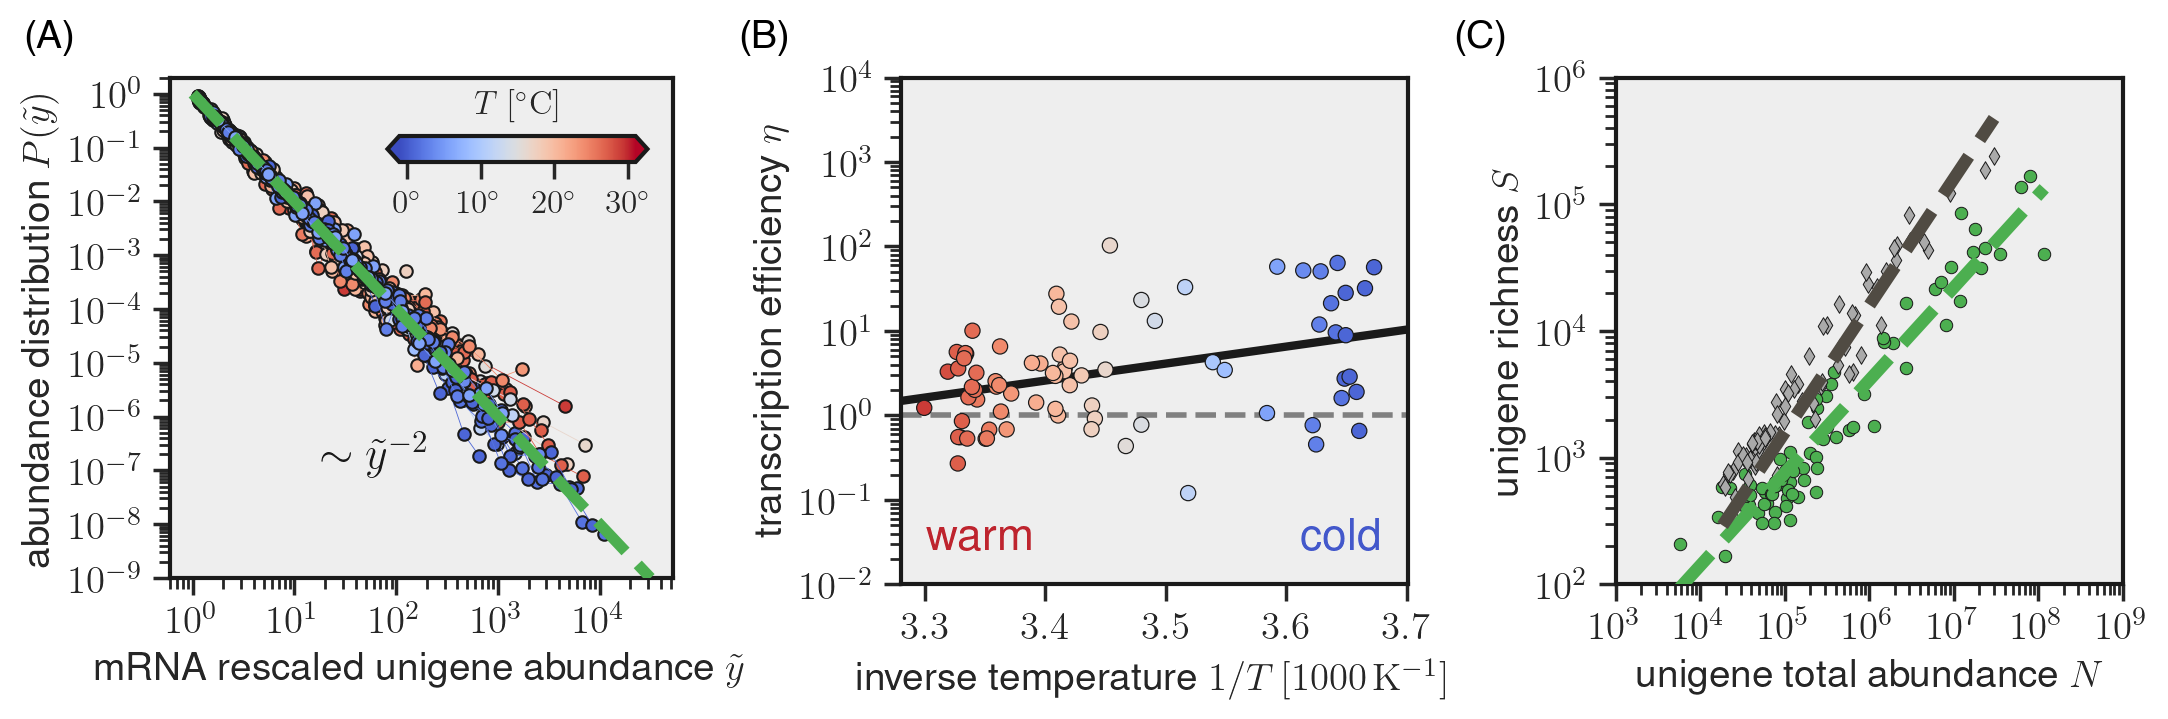

In [20]:
height = 3.24931369
phi = (1 + 5**0.5) / 2  # Golden ratio
bbox_props = dict(boxstyle="round", facecolor='white', edgecolor='black', linewidth=1)

fig, ax0 = plt.subplots(figsize=(height, height), constrained_layout=False)

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r"mRNA rescaled unigene abundance $\tilde{y}$")
ax0.set_ylabel(r"abundance distribution $P(\tilde{y})$")
ax0.set_facecolor("#EEEEEE")
ax0.set_ylim(1e-9, 2e0)
ax0.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax0.xaxis.set_major_formatter(LogFormatterMathtext())
ax0.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax0.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax0.yaxis.set_major_formatter(LogFormatterMathtext())
ax0.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax0.set_yticks([1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax0.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5])

meta = 'metaT'
for i, station in enumerate(df_meta[meta].sample(frac=1, random_state=42).columns):
    df = df_meta[meta]
    data = df[station]
    fit = df_fits[meta].loc[station]
    k, alpha, gamma, mu = 10**fit['logk'], fit['alpha'], 1, fit['mu_KS']
    data = data[~data.isna()]
    data = data[data >= mu]
    color = return_color_station(station, metadata, palette_temp=palette_temp)

    data_rescaled = ((data + k - mu) / k) ** alpha
    x, y = plot_logSAD(data_rescaled, nbins=20)
    sns.lineplot(x=x, y=y, ax=ax0, color=color, lw=0.3, marker=metamarker[meta], markersize=4.5, markeredgecolor='k')

    if i == 0:     
        xplot = np.logspace(0, 4.5, 100)
        yplot = 1*xplot**(-2)
        sns.lineplot(x=xplot, y=yplot, ax=ax0, color=metacolor[meta], lw=4, ls='--', zorder=10)

txt = r"$\sim \tilde{y}^{-2}$"
ax0.text(0.3, 0.2, txt, ha='left', va='bottom', transform=ax0.transAxes, fontsize=16, usetex=True, color='k')
#txt = r"$P(\tilde{y}) \sim \tilde{y}^{-2}$"
#ax0.text(0.07, 0.07, txt, ha='left', va='bottom', transform=ax0.transAxes, fontsize=16, usetex=True, fontweight='bold', color='k', bbox=bbox_props)

ax = fig.add_axes([1.25, 0.1, 0.78, 0.78])
ax1 = fig.add_axes([2.35, 0.1, 0.78, 0.78])

ax.set_facecolor("#EEEEEE") 
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e4)
ax.set_xticks(np.arange(3.3, 3.8, 0.1))
ax.set_xlim(3.28, 3.701)
ax.set_xlabel(r'inverse temperature $1/T\, [1000\, \mathrm{K}^{-1}]$' )
ax.set_ylabel(r'transcription efficiency $\eta$' )
ax.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(LogFormatterMathtext())

sns.scatterplot(x='inverseTemperature', y='kT/kG', data=gdf, ax=ax, palette=None, hue=None, s=30, edgecolor='k', alpha=1, zorder=3, c=gdf['color'].tolist())

x = gdf['inverseTemperature']
y = gdf['kT/kG']
x = x[y > 0]
y = y[y > 0]

slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.log(y))
K_boltmann = 8.617333262145e-5 # in eV/K
E = slope*K_boltmann*1e3
sigma_E = std_err*K_boltmann*1e3
print(f'Energies for {meta}: {E:1.2f}+-{sigma_E:1.2f} eV. p-value={p_value:1.4f}')
print(f'to/gamma1={np.exp(intercept)}')

y_fit = np.exp(slope*x + intercept)
xx = np.linspace(3.28, 3.7, 100)
yy = np.exp(slope*xx + intercept)
sns.lineplot(x=xx, y=yy, ax=ax, color='k', ls='-', zorder=2, lw=3)

ax.axhline(1, color='gray', ls='--', lw=2, zorder=1)

activation_energy = E
sigma_activation_energy = sigma_E
t0_over_gamma1 = np.exp(intercept)
n = len(x)
x_mean = np.mean(x)
std_err_intercept = std_err * np.sqrt(1/n + x_mean**2/np.sum((x - x_mean)**2))
std_t0_over_gamma1 = t0_over_gamma1 * std_err_intercept
print(np.exp(std_t0_over_gamma1), intercept)

print(f'activation energy: {activation_energy:1.2f}+-{sigma_E:1.2f} eV')
print(f't0/gamma1: {t0_over_gamma1:1.2e}+-{std_t0_over_gamma1:1.2e}')

print(np.exp(intercept - std_err_intercept), np.exp(intercept + std_err_intercept))

colorbar = True
if colorbar:
    cax = fig.add_axes([.46, 0.75, 0.4, 0.04])
    sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal', extend='both')
    cbar.ax.set_xticklabels([r'$0^\circ$', r'$10^\circ$', r'$20^\circ$', r'$30^\circ$'], fontsize=12, usetex=True)
    cbar.ax.set_title(r'$T\ [^\circ\mathrm{C}]$', fontsize=12, usetex=True, pad=8)

colors = sns.color_palette(palettename, 33)
ax.text(0.95, 0.05, "cold", ha='right', va='bottom', transform=ax.transAxes, fontsize=16, usetex=True, fontweight='bold', color=colors[0])
ax.text(0.05, 0.05, "warm", ha='left', va='bottom', transform=ax.transAxes, fontsize=16, usetex=True, fontweight='bold', color=colors[-1])

# txt = r"$\eta \sim e^{\frac{E}{k_B T}}$"
# ax.text(1-0.07, 0.8, txt, ha='right', va='bottom', transform=ax.transAxes, fontsize=16, usetex=True, fontweight='bold', bbox=bbox_props)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'unigene total abundance $N$')
ax1.set_ylabel(r'unigene richness $S$')
ax1.set_facecolor("#EEEEEE")
ax1.set_ylim(1e2, 1e6)
ax1.set_xlim(1e3, 1e9)
ax1.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax1.xaxis.set_major_formatter(LogFormatterMathtext())
ax1.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax1.yaxis.set_major_formatter(LogFormatterMathtext())
ax1.yaxis.set_minor_locator(plt.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))

x = N_metaT
y = S_metaT
logx = np.log10(x)
logy = np.log10(y)
slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
X = np.logspace(logx.min(), logx.max(), 10)
Y = 10**(slope*np.log10(X)+intercept)
label = r'$S \propto N^{{{}}}$'.format(round(slope, 2))
ax1.plot(X, Y, color=metaTcolor, ls='--', zorder=16, lw=4.5)
print(f"slope: {slope}, intercept: {intercept}, r_value: {r_value}, p_value: {p_value}, std_err: {std_err}")
sns.scatterplot(x=x, y=y, ax=ax1, color=metaTcolor, edgecolor='k', s=20, zorder=4)

x = N_metaG
y = S_metaG
logx = np.log10(x)
logy = np.log10(y)
slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
X = np.logspace(logx.min(), logx.max(), 10)
Y = 10**(fixed_slope*np.log10(X)-1.8)
label = r'$S \propto N^{{{}}}$'.format(round(slope, 2))
ax1.plot(X, Y, color=metaGcolor, ls='--', zorder=16, lw=4.5)
print(f"slope: {slope}, intercept: {intercept}, r_value: {r_value}, p_value: {p_value}, std_err: {std_err}")
sns.scatterplot(x=x, y=y, ax=ax1, color='#AAAAAA', edgecolor='k', s=20, zorder=4, marker=metamarker['metaG'])

txt = r"$S_T \sim N_T^\xi$"
# ax1.text(1-0.07, 0.07, txt, ha='right', va='bottom', transform=ax1.transAxes, fontsize=16, usetex=True)#, fontweight='bold', bbox=bbox_props)
# txt = r"$S_G \sim N_G$"
# ax1.text(0.07, 0.8, txt, ha='left', va='bottom', transform=ax1.transAxes, fontsize=16, usetex=True, fontweight='bold', bbox=bbox_props)

fig.text(-0.1, 0.97, '(A)', ha='left', va='top', fontsize=14, color='black', usetex=False)
fig.text(1., 0.97, '(B)', ha='left', va='top', fontsize=14, color='black', usetex=False)
fig.text(2.1, 0.97, '(C)', ha='left', va='top', fontsize=14, color='black', usetex=False)

figname = '../figures/fig4'
plt.savefig(f'{figname}.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()
